In [1]:
import sys
import os
import pickle
import random
import copy

from Bio import SeqIO
import numpy as np
import pandas as pd
import matplotlib     
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from matplotlib.colors import ListedColormap


from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS

sys.path.append('../../settings/')
import settings

sys.path.append('../common/')
import data_io_utils
import plot_style_utils

import A007_common

%reload_ext autoreload
%autoreload 2

np.random.seed(1)
random.seed(1)

In [2]:
AGGREGATED_MUTANT_DATA_DIR = os.path.join(A007_common.MLPE_GFP_DATA_DIR, 
        'Clean_FPbase_aggregated_parents_and_mutant_dfs')
data_io_utils.sync_s3_path_to_local(AGGREGATED_MUTANT_DATA_DIR)

In [3]:
DROP_EVOTUNE_DUPLICATES=True

if DROP_EVOTUNE_DUPLICATES:
    DUP_DF = pd.read_csv(os.path.join(AGGREGATED_MUTANT_DATA_DIR, 'Fig5_Aequorea_GFPs_not_in_evotrain_actual.csv'), 
            index_col=0)
    display(DUP_DF.head()) # Keep these sequences in the generalization set.

,name,seq
0,W1C,MASKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLK...
1,GFP-151pyTyrCu,MSKGAELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
2,GFP-Tyr151pyz,MSKGEALFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
3,P4-1,MASKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLK...
7,cpCitrine,MVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLK...


In [42]:
import Levenshtein

avGFP_idx = int(np.argwhere(DUP_DF['name'] == 'avGFP_internal'))
avGFP_seq = DUP_DF['seq'].iloc[avGFP_idx]

ld = np.array([Levenshtein.distance(avGFP_seq, s) for s in list(DUP_DF['seq'])])
(np.min(ld[ld > 0]), np.max(ld))

(2, 19)

Baseline predictions

In [4]:
BASELINE_FILE = os.path.join(AGGREGATED_MUTANT_DATA_DIR, 'baselines', 
        'aggregated_parents_and_mutant_metadata_with_computed_baselines.csv')
data_io_utils.sync_s3_path_to_local(BASELINE_FILE, is_single_file=True)

BASELINE_REPS = [
    'pred_brightness_arnold_original_3_7', 
    'pred_brightness_arnold_uniform_4_1',
    'pred_brightness_arnold_scrambled_3_5',
    'pred_brightness_simple_freq_plus',
    'pred_brightness_arnold_random_3_7'
]

BASELINE_REP_NAMES = [
    'Doc2Vec Original k=3 w=7', 
    'Doc2Vec Uniform k=4 w=1',
    'Doc2Vec Scrambled k=3 w=5',
    'Simple Freq. Plus',
    'Best Doc2Vec', #'Doc2Vec Random k=3 w=7'
]

BASELINE_DF = pd.read_csv(BASELINE_FILE)
BASELINE_DF.head()

,Unnamed: 0,mutant_name,parent,num_mutations,actual_ow_imputed_brightness,seq,pred_brightness_arnold_uniform_4_1,pred_brightness_arnold_random_3_7,pred_brightness_arnold_scrambled_3_5,pred_brightness_arnold_original_3_7,pred_brightness_simple_freq_plus
0,0,W1C,W1C,0.0,8.27,MASKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLK...,0.449272,0.366741,0.639585,0.556602,0.775370
1,1,GFP-151pyTyrCu,GFP-151pyTyrCu,0.0,19.75,MSKGAELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0.250613,0.329268,-0.135136,-0.175582,0.122746
2,2,GFP-Tyr151pyz,GFP-Tyr151pyz,0.0,19.75,MSKGEALFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0.513405,0.550074,0.617829,0.566627,0.431210
3,3,P4-1,P4-1,0.0,7.83,MASKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLK...,0.500161,0.740672,0.770521,0.606751,0.685035
4,4,sg25,sg25,0.0,19.91,MASKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLK...,0.399622,0.565637,0.670850,0.486854,0.629398


In [5]:
BASELINE_REPS

['pred_brightness_arnold_original_3_7',
 'pred_brightness_arnold_uniform_4_1',
 'pred_brightness_arnold_scrambled_3_5',
 'pred_brightness_simple_freq_plus',
 'pred_brightness_arnold_random_3_7']

## Plot style context

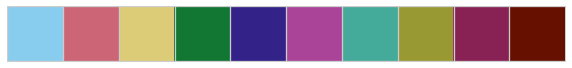

In [6]:
plot_style_utils.set_pub_plot_context(context="talk", colors="categorical")
CAT_COLORS = sns.color_palette()
tmp = CAT_COLORS[3]
CAT_COLORS[3] = CAT_COLORS[7]
CAT_COLORS[7] = tmp
MPL_CMAP = ListedColormap(sns.color_palette().as_hex())

sns.palplot(sns.color_palette())
plt.show()

In [7]:
def compute_budget_constrained_functional_sequence_recovery_performance_metrics(
    representation, max_nmut_pos=0.0, min_nmut_neg=6.0, n_budgets=200, linspace_budgets=False,
    n_boot=100):
    
    if representation == 'null' or representation == 'ideal':
        # dataframe only needed for true values
        agg_mutant_df = pd.read_csv(os.path.join(AGGREGATED_MUTANT_DATA_DIR, 'pbab' + '.csv')) 
    elif representation in BASELINE_REPS:
        agg_mutant_df = BASELINE_DF[
            ['mutant_name', 'parent', 'num_mutations', 'actual_ow_imputed_brightness', 'seq', representation]]
        agg_mutant_df.rename(columns={representation: 'pred_brightness'}, inplace=True)
    else:
        agg_mutant_df = pd.read_csv(os.path.join(AGGREGATED_MUTANT_DATA_DIR, representation + '.csv'))
        
    
    if DROP_EVOTUNE_DUPLICATES:
        ids_to_keep = list(DUP_DF['name'])
        parents = list(agg_mutant_df['parent'])
        to_keep = np.array([p in ids_to_keep for p in parents])
        agg_mutant_df = agg_mutant_df[to_keep]
        
    positive_sequence_mask = agg_mutant_df['num_mutations'] <= max_nmut_pos
    negative_sequence_mask = agg_mutant_df['num_mutations'] >= min_nmut_neg
    
    y_pos = np.array(agg_mutant_df['actual_ow_imputed_brightness'])[positive_sequence_mask]
    y_neg = np.zeros(np.sum(negative_sequence_mask))

    if representation == 'null':
        yhat_pos = np.random.rand(len(y_pos))
        yhat_neg = np.random.rand(len(y_neg))
        
    elif representation == 'ideal':
        yhat_pos = copy.deepcopy(y_pos)
        yhat_neg = copy.deepcopy(y_neg)
    
    else:
        yhat_pos = np.array(agg_mutant_df['pred_brightness'])[positive_sequence_mask]
        yhat_neg = np.array(agg_mutant_df['pred_brightness'])[negative_sequence_mask]
        
    BUDGETS = np.unique(np.round(np.sort(
            np.concatenate([np.logspace(1, np.log10(len(yhat_pos)+len(yhat_neg)), n_budgets),
            np.array([96.0, 384.0])] ))).astype(int))
    results = A007_common.budget_constrained_bootstrap_performance(yhat_pos, yhat_neg, y_pos, y_neg, 
        BUDGETS, n_boot=n_boot, mode=representation)
    
    bmat = np.vstack([np.expand_dims(r['brightest'],0) for r in results])
    fdrmat = np.vstack([np.expand_dims(r['fdr'],0) for r in results])
    recallmat = np.vstack([np.expand_dims(r['recall'],0) for r in results])
    budgets = results[0]['budgets']

    results_summary = {
        'brightest_mat': bmat,
        'mean_brightest': np.mean(bmat, axis=0),
        'std_brightest': np.std(bmat, axis=0),
        'fdr_mat': fdrmat,
        'mean_fdr': np.mean(fdrmat, axis=0),
        'std_fdr': np.std(fdrmat, axis=0),
        'recall_mat': recallmat,
        'mean_recall': np.mean(recallmat, axis=0),
        'std_recall': np.std(recallmat, axis=0),
        'budgets': budgets,
    }
    
    return results_summary

In [8]:
REPS = [
    'null', 
    'ideal', 
    'pbab', 
    'finetune1', 
    'random1', 
]
REPS += BASELINE_REPS

REP_NAMES = [
    'Null Model',
    'Ideal Model',
    'UniRep', 
    'Evotuned UniRep',
    'Evotuned Random'
]
REP_NAMES += BASELINE_REP_NAMES

COLORS = [
    [0.5, 0.5, 0.5], 
    [0, 0, 0], 
    CAT_COLORS[0], 
    CAT_COLORS[1], 
    CAT_COLORS[2], 
]
COLORS += CAT_COLORS[3:3+len(BASELINE_REPS)]


DATA_SUBSAMPLED_REPS = []
DATA_SUBSAMPLED_COLORS = []
for r in ['finetune1', 'random1', 'pbab']:
    start_color = COLORS[REPS == '']
    for nsub in A007_common.A007k_N_SUBSAMPLES:
        for i in range(len(A007_common.A007k_SEEDS)):
            DATA_SUBSAMPLED_REPS.append(r + '_' + str(nsub) + '_' + str(i))

## Budget constrained bootstrap performance for the top-model on reps trained w/ full data.

In [9]:
if DROP_EVOTUNE_DUPLICATES:
    results_file = 'figure_related/budget_constrained_bootstrapping_results_evo_dup_dropped.p'
else:
    results_file = 'figure_related/budget_constrained_bootstrapping_results.p'

if not os.path.exists(results_file):
    np.random.seed(1)
    random.seed(1)
    
    res = []
    for rep in REPS:
        print(rep)
        if rep == 'null':
            res.append(compute_budget_constrained_functional_sequence_recovery_performance_metrics(
                    rep, max_nmut_pos=0.0, min_nmut_neg=6.0, n_budgets=400, 
                    linspace_budgets=False, n_boot=10000) 
            )
        else:
            res.append(compute_budget_constrained_functional_sequence_recovery_performance_metrics(
                    rep, max_nmut_pos=0.0, min_nmut_neg=6.0, n_budgets=400, 
                    linspace_budgets=False, n_boot=1000) 
            )
            
    
    with open(results_file, 'wb') as f:
        pickle.dump(res, f)
else:
    with open(results_file, 'rb') as f:
        res = pickle.load(f)

In [52]:
print(res[1]['budgets'][:10])
print(res[1]['mean_recall'][:10]*27)
print(res[3]['mean_recall'][:10]*27)

[10 11 12 13 14 15 16 17 18 19]
[10. 11. 12. 13. 14. 15. 16. 17. 18. 19.]
[ 9.68  10.437 11.115 11.741 12.304 12.834 13.359 13.877 14.415 14.953]


In [51]:
19/27

0.7037037037037037

## Data subsampled trained top-models on reps.

To answer data efficiency question

In [10]:
if DROP_EVOTUNE_DUPLICATES:
    results_file = 'figure_related/data_subsampled_budget_constrained_bootstrapping_results_evo_dup_dropped.p'
else:
    results_file = 'figure_related/data_subsampled_budget_constrained_bootstrapping_results.p'

if not os.path.exists(results_file):
    np.random.seed(1)
    random.seed(1)
    subsamp_res = [compute_budget_constrained_functional_sequence_recovery_performance_metrics(
            rep, max_nmut_pos=0.0, min_nmut_neg=6.0, n_budgets=400, linspace_budgets=False, n_boot=100) 
           for rep in DATA_SUBSAMPLED_REPS]
    
    with open(results_file, 'wb') as f:
        pickle.dump(subsamp_res, f)
else:
    with open(results_file, 'rb') as f:
        subsamp_res = pickle.load(f)

In [11]:
len(subsamp_res)

36

## Recall and max-brightness recovery curves. 

In [12]:
def plot_results(res, metric, colors, ylabel, legend=True, show_only=None):
    
    if show_only is None:
        show_only = REP_NAMES
    
    fig = plt.figure(figsize=plot_style_utils.STANDARD_FIG_SIZE)
    mean_key = 'mean_' + metric
    std_key = 'std_' + metric
    
    for i,r in enumerate(res):
        if REP_NAMES[i] in show_only:
        
            normval = np.max(r[mean_key])
            mean_vals = r[mean_key]/normval
            std_vals = r[std_key]/(normval)

            if REP_NAMES[i] == 'Ideal Model':
                plt.plot(r['budgets'], mean_vals, '-', color=colors[i], zorder=8)
            else:
                plt.plot(r['budgets'], mean_vals, '-', color=colors[i])

            if REP_NAMES[i] != 'Ideal Model':
                plt.fill_between(r['budgets'], mean_vals-std_vals, mean_vals+std_vals, 
                                 color=colors[i], alpha=0.4)
    
    
    plt.xscale('log')
    plt.xlabel('Testing budget (num. sequences)')
    plt.ylabel(ylabel)
    if legend:
        plt.legend(show_only, loc='lower right', fontsize=12, bbox_to_anchor=(0.78, -0., 0.94, 0.5))
        
    if metric == 'brightest':
        plt.axis('tight')
        plt.ylim(0,1.01)
        plt.xlim(np.min(r['budgets']), np.max(r['budgets']))
        
    if metric == 'recall':
        plt.axis('tight')
        plt.ylim(0,1.01)
        plt.xlim(np.min(r['budgets']), np.max(r['budgets']))
    
    plt.show()
    return fig

In [13]:
MINIMAL_SUBSET_TO_PLOT = ['Null Model', 'Ideal Model', 'UniRep', 'Evotuned UniRep', 
                   'Evotuned Random', 'Best Doc2Vec']

/home/ubuntu/GitHub/protein-representation-learning-analysis/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


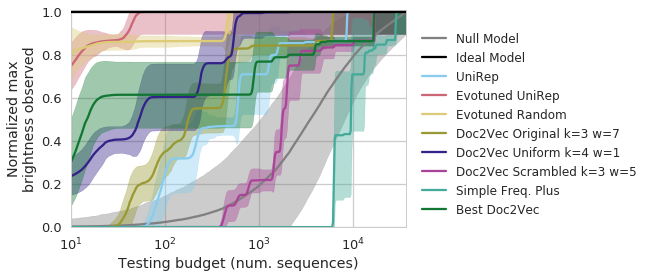

In [14]:
fig = plot_results(res, 'brightest', COLORS, 'Normalized max\nbrightness observed')
plot_style_utils.save_for_pub(fig, 
    path='figure_related/max_brightness_vs_budget_dedup-' + str(DROP_EVOTUNE_DUPLICATES), dpi=300)

/home/ubuntu/GitHub/protein-representation-learning-analysis/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


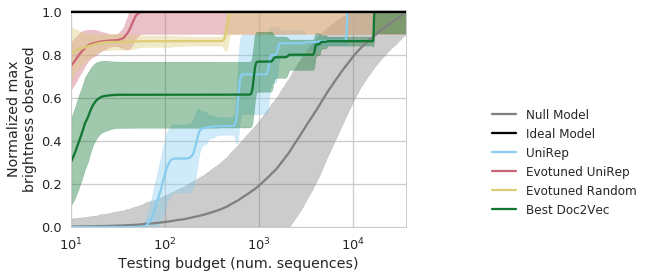

In [15]:
fig = plot_results(res, 'brightest', COLORS, 'Normalized max\nbrightness observed', 
        show_only=MINIMAL_SUBSET_TO_PLOT)

plot_style_utils.save_for_pub(fig, 
    path='figure_related/max_brightness_vs_budget_dedup-' + str(DROP_EVOTUNE_DUPLICATES) + '_subset_shown', dpi=300)

/home/ubuntu/GitHub/protein-representation-learning-analysis/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


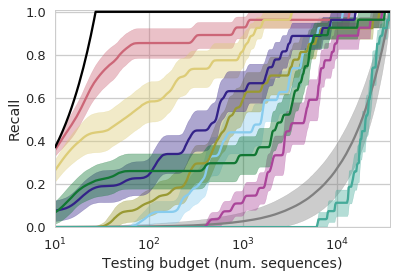

In [16]:
fig = plot_results(res, 'recall', COLORS, 'Recall', legend=False)
plot_style_utils.save_for_pub(fig, 
    path='figure_related/recall_vs_budget_dedup-' + str(DROP_EVOTUNE_DUPLICATES), dpi=300)

/home/ubuntu/GitHub/protein-representation-learning-analysis/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


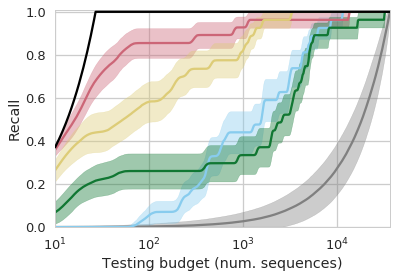

In [17]:
fig = plot_results(res, 'recall', COLORS, 'Recall', legend=False, 
        show_only=MINIMAL_SUBSET_TO_PLOT)
plot_style_utils.save_for_pub(fig, 
    path='figure_related/recall_vs_budget_dedup-' + str(DROP_EVOTUNE_DUPLICATES) + '_subset_shown', dpi=300)

### Recall and max brightness curves for data subsampled models

In [18]:
def plot_metric_curve(results_dict, metric, color, show_error_bands=True):
    mean_key = 'mean_' + metric
    std_key = 'std_' + metric
    
    normval = np.max(results_dict[mean_key])
    
    plt.plot(results_dict['budgets'], results_dict[mean_key]/normval, '-', color=color)
    
    if show_error_bands:
        plt.fill_between(results_dict['budgets'], 
                     (results_dict[mean_key]-results_dict[std_key])/normval, 
                     (results_dict[mean_key]+results_dict[std_key])/normval, 
                     color=color, alpha=0.4)

/home/ubuntu/GitHub/protein-representation-learning-analysis/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


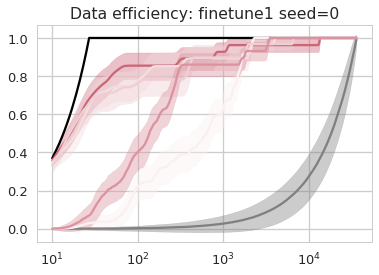

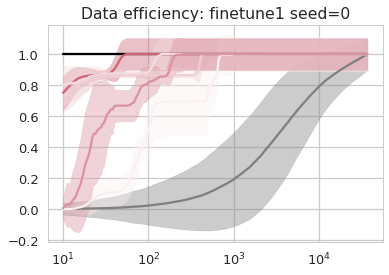

In [19]:
metrics = ['recall', 'brightest']
SEED = 0
DATA_SUBSAMPLED_REP = 'finetune1'


null_idx = int(np.argwhere(np.array(REPS) == 'null'))
ideal_idx = int(np.argwhere(np.array(REPS) == 'ideal'))
rep_full_data_idx = int(np.argwhere(np.array(REPS) == DATA_SUBSAMPLED_REP))

NULL_RESULTS_DICT = res[null_idx]
IDEAL_RESULTS_DICT = res[ideal_idx]
REP_FULL_DATA_RESULTS_DICT = res[rep_full_data_idx]
BUDGETS = NULL_RESULTS_DICT['budgets']



init_color = COLORS[int(np.argwhere(np.array(REPS) == DATA_SUBSAMPLED_REP))]
end_color = [1., 1., 1.]
for m in metrics:
    plt.figure()
    mean_key = 'mean_' + m
    std_key = 'std_' + m
    
    # Null and Idea and full data  model curves
    plot_metric_curve(NULL_RESULTS_DICT, m, COLORS[null_idx], show_error_bands=True)
    plot_metric_curve(IDEAL_RESULTS_DICT, m, COLORS[ideal_idx], show_error_bands=False)
    plot_metric_curve(REP_FULL_DATA_RESULTS_DICT, m, COLORS[rep_full_data_idx], show_error_bands=True)
        
    
    for i,nsub in enumerate(A007_common.A007k_N_SUBSAMPLES):
        rep_name = DATA_SUBSAMPLED_REP + '_' + str(nsub) + '_' + str(SEED)
        rep_results_dict = subsamp_res[int(np.argwhere(np.array(DATA_SUBSAMPLED_REPS) == rep_name))]
        
        
        w = np.sqrt(nsub)/np.sqrt(10000.0)
        color = list(w*np.array(init_color) + (1-w)*np.array(end_color))
        plot_metric_curve(rep_results_dict, m, color, show_error_bands=True)
             
    plt.title('Data efficiency: ' + DATA_SUBSAMPLED_REP + ' seed=' +str(SEED))        
    plt.xscale('log')
    plt.show()


## Efficiency calculations

In [20]:
def calculate_efficiencies_at_budget(budget, budgets, metric_mat):
    return metric_mat[:,budgets == budget]/budget
    
def calculate_efficiency_gain_over_null_model(rep_results_dict, null_results_dict,
        metric, budget, pseudocount=0):
    
    null_eff_vec = calculate_efficiencies_at_budget(budget, budgets, 
            null_results_dict[metric + '_mat'])
    rep_eff_vec = calculate_efficiencies_at_budget(budget, budgets, 
            rep_results_dict[metric + '_mat'])
    
    return (rep_eff_vec/(np.mean(null_eff_vec) + pseudocount)).reshape(-1)

def calc_efficiency_gain_over_null_model_curve_for_rep(rep_results_dict, null_results_dict,
        metric, budgets):
    
    ecurve = []
    for b in budgets:
        ecurve.append(np.mean(calculate_efficiency_gain_over_null_model(
            rep_results_dict, null_results_dict, metric, b)))
        
    return ecurve    

### Efficiency calculations for data using all avGFP data to build top model

/home/ubuntu/GitHub/protein-representation-learning-analysis/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


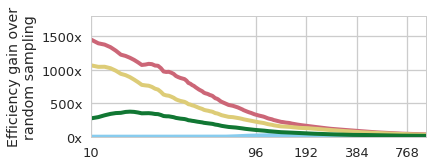

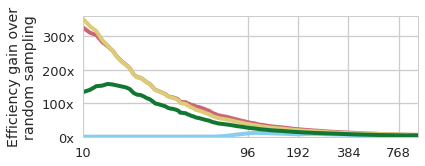

In [21]:
metrics = ['recall', 'brightest']
budgets = res[0]['budgets']
rep_vals = REPS[2:]
rep_name_vals = REP_NAMES[2:]
color_vals = COLORS[2:]

xticks = [10, 96, 192, 384, 768]

NULL_RESULTS_DICT = res[int(np.argwhere(np.array(REPS) == 'null'))]

figsize = list(plot_style_utils.STANDARD_FIG_SIZE)
figsize[1] = figsize[1]/1.8

for m in metrics:
    fig = plt.figure(figsize=figsize)

    for i,r in enumerate(rep_vals):
        if rep_name_vals[i] in MINIMAL_SUBSET_TO_PLOT:
            rep_results_dict = res[int(np.argwhere(np.array(REPS) == r))]

            ec = calc_efficiency_gain_over_null_model_curve_for_rep(
                    rep_results_dict, NULL_RESULTS_DICT, m, budgets)

            plt.plot(budgets, ec, '-', color=color_vals[i], linewidth=4, label=rep_name_vals[i])
      
    plt.xscale('log')
    plt.xlim(10, 1000)
#     if m == 'brightest':
#         plt.legend()
    plt.xticks(xticks)
    
    plt.gca().set_xticklabels(xticks)
    
    ticks, labels = plt.yticks()
    new_labels = ['%0.0fx' % t for t in list(ticks)]
    plt.yticks(ticks, new_labels)
    plt.ylim(0, np.max(ticks)*0.9)

    
    #plt.title(m)
    plt.ylabel('Efficiency gain over\nrandom sampling')
    plt.show()
    plot_style_utils.save_for_pub(fig,
            path='figure_related/efficiency_gain_' + m + '_dedup-' + str(DROP_EVOTUNE_DUPLICATES),
            dpi=300)

### Efficiency calculations for finetune1 (Evotuned UniRep) with top models trained on subsampled avGFP data.

In [22]:
# metrics = ['recall', 'brightest']
# budgets = res[0]['budgets']

# xticks = [10, 96, 192, 384, 768, 1000]

# NULL_RESULTS_DICT = res[int(np.argwhere(np.array(REPS) == 'null'))]
# MIX_COLOR = [0.1, 0.3, 1.0]
# DATA_SUBSAMPLED_REP = 'finetune1'
# for m in metrics:
#     plt.figure(figsize=(24, 6))

#     init_color = COLORS[int(np.argwhere(np.array(REPS) == DATA_SUBSAMPLED_REP))]

#     for n, nsub in enumerate(A007_common.A007k_N_SUBSAMPLES):
        
#         plt.subplot(1,len(A007_common.A007k_N_SUBSAMPLES),n+1)
#         plt.title('N='+str(nsub))
#         for i in range(len(A007_common.A007k_SEEDS)):
#             rep_name = r + '_' + str(nsub) + '_' + str(i)

#             rep_results_dict = subsamp_res[int(np.argwhere(np.array(DATA_SUBSAMPLED_REPS) == rep_name))]

#             w = np.sqrt(nsub*5)/np.sqrt(50000)
#             c = list(np.array(init_color)*w + (1-w)*np.array(MIX_COLOR))
#             ec = calc_efficiency_gain_over_null_model_curve_for_rep(
#                 rep_results_dict, NULL_RESULTS_DICT, m, budgets)

#             plt.plot(budgets, ec, '-', color=init_color, linewidth=2)

            
#         plt.xlim(0, 1000)
#         plt.xticks(xticks)
#         if n == 0:
#             plt.ylabel('Efficiency gain over\nrandom sampling')
    
#     plt.show()
            
            

## Decreasing fitness w/ increasing mutations plot.

In [23]:
SARK_DECAY_CURVE = np.array([1.        , 0.88052853, 0.84446468, 0.7085515 , 0.52117676,
       0.3393034 , 0.21132682, 0.12987359, 0.09449948, 0.06456735,
       0.0605614 , 0.04543888, 0.07460468, 0.04912072, 0.05385919,
       0.01770657])

def compute_predicted_mutational_decay_curves(rep):
    agg_mutant_fine_df = pd.read_csv(os.path.join(AGGREGATED_MUTANT_DATA_DIR, rep + '.csv')) 
    parents = np.unique(list(agg_mutant_fine_df['parent']))
    nmuts = np.unique(list(agg_mutant_fine_df['num_mutations']))
    
    decay_curves = []
    for parent in parents:
        c = []
        for nmut in nmuts:
            mask = np.logical_and(agg_mutant_fine_df['parent'] == parent, 
                    agg_mutant_fine_df['num_mutations'] == nmut)
            c.append(np.mean(agg_mutant_fine_df[mask]['pred_brightness']))

        c = np.array(c)
        decay_curves.append(c/c[0]) # normalize
        
    return decay_curves
        
def plot_decay_curves(decay_curves):
    
    for i,curve in enumerate(decay_curves):
        if i != len(decay_curves)-1:
            plt.plot(curve, '-', alpha=0.2, color=[0.6, 0.6, 0.6], label='_nolegend_')
        else:
            plt.plot(curve, '-', alpha=0.2, color=[0.6, 0.6, 0.6])

    plt.plot(SARK_DECAY_CURVE, '-', linewidth=4, color=CAT_COLORS[1])

    plt.ylim(-0.3,1.03)
    plt.xlim(0, len(curve)-1)
    plt.legend(['Predicted', 'Empirical'])
    plt.ylabel('Normalized predicted brightness')
    plt.xlabel('Number of mutations relative to parent')


In [24]:
rep_vals = ['pbab', 'random1', 'finetune1']
rep_name_vals = ['UniRep', 'Evotuned Random', 'Evotuned UniRep']

decay_curve_list = [compute_predicted_mutational_decay_curves(r) for r in rep_vals]

0.9611526295605706
0.954754371847839
0.9795964864177197


/home/ubuntu/GitHub/protein-representation-learning-analysis/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


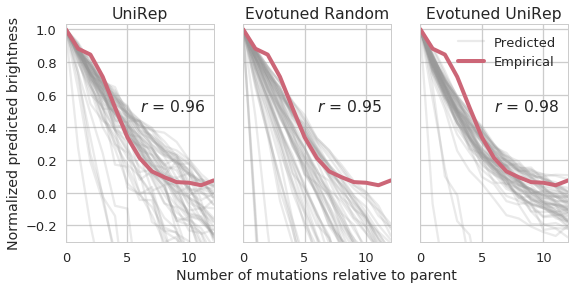

In [25]:
fig, ax = plt.subplots(1,3, figsize=(plot_style_utils.STANDARD_FIG_SIZE[0]*1.5,plot_style_utils.STANDARD_FIG_SIZE[1]))
for i,dc in enumerate(decay_curve_list):
    plt.subplot(1,3,i+1)
    plot_decay_curves(dc)
    plt.title(rep_name_vals[i])
    if i > 0:
        plt.ylabel('')
        plt.gca().set_yticklabels('')
        
    if i != 1:
        plt.xlabel('')
        
    if i != 2:
        plt.legend('')
    
    mdc = np.nanmean(np.vstack(dc), axis=0)
    pearson_val = np.corrcoef(SARK_DECAY_CURVE[:len(mdc)], mdc)[0,1]
    print(pearson_val)
    
    plt.text(6, 0.5, '$\it{r}$ = %0.2f' % pearson_val)
    
        
        
plot_style_utils.save_for_pub(fig, 
        path='figure_related/mutational_decay_curves'+ '_dedup-' + str(DROP_EVOTUNE_DUPLICATES),
        dpi=300)

In [26]:
import matplotlib
matplotlib.rcParams['font.family']

['Arial']

In [27]:
plot_style_utils.set_pub_plot_context(context="talk", colors="categorical")
CAT_COLORS = sns.color_palette()

In [28]:
start_val = 0
end_val = 7*np.pi
border = 30

blendfunc = lambda x: 1/(1 + np.exp(-5*(x-start_val))) - 1/(1 + np.exp(-5*(x-end_val)))
x = np.linspace(start_val-border, end_val+border, 1000)
x_in = np.linspace(start_val-0.5*np.pi, end_val+0.5*np.pi, 1000)

/home/ubuntu/GitHub/protein-representation-learning-analysis/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


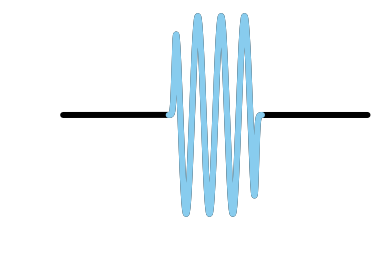

In [29]:
fig = plt.figure()
plt.plot(x, blendfunc(x)*np.cos(x), '-k', linewidth=6)
plt.plot(x_in, np.cos(x_in)*blendfunc(x_in), '-', color=CAT_COLORS[0], linewidth=6)
plt.axis('off')

plot_style_utils.save_for_pub(fig, path='figure_related/alpha_helix_splay', dpi=300)